In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
current_env = "local"

if current_env == "local":
    data_path = "../ump-dataset"

elif current_env == "kaggle":
    data_path = "../input/ump-dataset"
    
elif current_env == "colab":
    pass

print("data_path:", data_path)

data_path: ../ump-dataset


***
## loading data

In [3]:
features = [f"f_{i}" for i in range(300)]

features = pd.read_parquet(f"{data_path}/train.parquet", columns=features)
display(features)

target = pd.read_parquet(f"{data_path}/train.parquet", columns=["target",])
display(target)

time = pd.read_parquet(f"{data_path}/train.parquet", columns=["time_id",])
display(time)

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,0.965623,1.230508,0.114809,-2.012777,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,1.428127,1.134144,0.114809,-0.219201,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,0.979656,-1.125681,0.114809,-1.035376,...,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,0.778096,0.298990,0.114809,-1.176410,...,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,-0.946789,1.230508,0.114809,-0.005858,...,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3141405,0.093530,-0.720275,-0.345497,-0.438781,-0.166972,-0.437182,1.475746,1.284423,0.056425,-1.433681,...,-0.285908,-1.232434,-0.660579,0.875537,0.421628,-0.428097,-0.075548,-0.533092,-0.193732,-0.581394
3141406,-1.344935,-0.199987,-0.107702,-0.454677,-0.221914,-0.141174,-1.498235,1.373834,0.056425,-1.211572,...,0.184517,-1.232434,-0.670493,0.875537,0.421628,-0.729949,-1.514277,0.013145,-0.890270,-0.589705
3141407,0.979489,-1.110491,1.006980,-0.467307,-0.159549,1.355671,0.150812,-0.088923,0.056425,0.996380,...,-0.756332,-1.232434,0.820784,-1.142157,0.421628,-0.363329,1.363181,-0.079106,-1.580124,-0.297625
3141408,-2.565332,0.320301,0.076600,1.380182,-0.155366,-0.689000,0.381069,-1.324759,0.056425,-1.111730,...,-0.756332,-1.232434,0.133074,-1.142157,0.421628,-0.375288,-1.514277,-0.973762,0.608647,-0.372040


,target
0,-0.300875
1,-0.231040
2,0.568807
3,-1.064780
4,-0.531940
...,...
3141405,0.033600
3141406,-0.223264
3141407,-0.559415
3141408,0.009599


,time_id
0,0
1,0
2,0
3,0
4,0
...,...
3141405,1219
3141406,1219
3141407,1219
3141408,1219


In [4]:
time_ids = np.sort(time.time_id.unique())
len(time_ids)

1211

In [5]:
n_time_steps = len(time_ids)
print("time steps:", n_time_steps)

valid_prop = 0.1
valid_size = int(0.1 * n_time_steps)
print("valid size:", valid_size)

time steps: 1211
valid size: 121


In [6]:
# train-valid splits
n_splits = 3
end_idx = n_time_steps 

splits = list()

for start_idx in np.arange(1211, 0, -valid_size)[1:n_splits+1]:
    valid_time_ids = time_ids[start_idx:end_idx]
    train_time_end = time_ids[start_idx]-1
    end_idx = start_idx
    
    train_idx = time.query("time_id <= @train_time_end").index
    valid_idx = time.query("time_id in @valid_time_ids").index
    splits.append((train_idx,valid_idx))

In [7]:
import gc
gc.collect()

144

***
## model training: evaluation

In [8]:
def pearsonr(preds: np.array, dset: lgb.Dataset):
    """
    Helper function to compute Pearson correlation 
    on validation dataset for LightGBM as tracking metric.
    Args:
        preds: 1d-array with the model predictions
        dset: LightGBM dataset with the labels
    Returs:
        Tuple with the corresponding output
    """
    labels = dset.get_label()
    return 'pearsonr', stats.pearsonr(preds, labels)[0], True

In [9]:
model_params = {
    'boosting': 'dart',
    'objective': 'mse',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'force_col_wise': True,
    'bagging_freq': 1,
    'seed': 19,
    'verbosity': -1,
    'first_metric_only': False,
    'bin_construct_sample_cnt': 100000000,
    'feature_pre_filter': False,
    'bagging_fraction': 0.9,
    'drop_rate': 0.05,
    'feature_fraction': 0.35,
    'lambda_l1': 0.0030634425257422774,
    'lambda_l2': 0.47750267260754264,
    'max_drop': 30,
    'min_data_in_leaf': 900,
    'num_iterations': 1800,
    'path_smooth': 7.379773979102196,
    'skip_drop': 0.5,
    'num_leaves': 128
}

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's rmse: 0.897288	valid_0's pearsonr: 0.130288


[100]	valid_0's rmse: 0.896653	valid_0's pearsonr: 0.133872


[150]	valid_0's rmse: 0.895776	valid_0's pearsonr: 0.136137


[200]	valid_0's rmse: 0.895498	valid_0's pearsonr: 0.137213


[250]	valid_0's rmse: 0.895224	valid_0's pearsonr: 0.138253


[300]	valid_0's rmse: 0.895052	valid_0's pearsonr: 0.138792


[350]	valid_0's rmse: 0.894841	valid_0's pearsonr: 0.139276


[400]	valid_0's rmse: 0.894542	valid_0's pearsonr: 0.141042


[450]	valid_0's rmse: 0.894401	valid_0's pearsonr: 0.142068


[500]	valid_0's rmse: 0.894388	valid_0's pearsonr: 0.142147


[550]	valid_0's rmse: 0.894196	valid_0's pearsonr: 0.143015


[600]	valid_0's rmse: 0.894102	valid_0's pearsonr: 0.143338


[650]	valid_0's rmse: 0.894087	valid_0's pearsonr: 0.143716


[700]	valid_0's rmse: 0.89401	valid_0's pearsonr: 0.144254


[750]	valid_0's rmse: 0.894009	valid_0's pearsonr: 0.144178


[800]	valid_0's rmse: 0.893955	valid_0's pearsonr: 0.144342


[850]	valid_0's rmse: 0.893928	valid_0's pearsonr: 0.144721


[900]	valid_0's rmse: 0.893851	valid_0's pearsonr: 0.145115


[950]	valid_0's rmse: 0.893824	valid_0's pearsonr: 0.145096


[1000]	valid_0's rmse: 0.893739	valid_0's pearsonr: 0.145628


[1050]	valid_0's rmse: 0.893702	valid_0's pearsonr: 0.145644


[1100]	valid_0's rmse: 0.893696	valid_0's pearsonr: 0.145613


[1150]	valid_0's rmse: 0.893725	valid_0's pearsonr: 0.145332


[1200]	valid_0's rmse: 0.893668	valid_0's pearsonr: 0.145497


[1250]	valid_0's rmse: 0.893706	valid_0's pearsonr: 0.145044


[1300]	valid_0's rmse: 0.893718	valid_0's pearsonr: 0.144949


[1350]	valid_0's rmse: 0.893662	valid_0's pearsonr: 0.145385


[1400]	valid_0's rmse: 0.893668	valid_0's pearsonr: 0.14531


[1450]	valid_0's rmse: 0.893619	valid_0's pearsonr: 0.145659


[1500]	valid_0's rmse: 0.893642	valid_0's pearsonr: 0.145487


[1550]	valid_0's rmse: 0.893595	valid_0's pearsonr: 0.145839


[1600]	valid_0's rmse: 0.89361	valid_0's pearsonr: 0.145727


[1650]	valid_0's rmse: 0.893597	valid_0's pearsonr: 0.145848


[1700]	valid_0's rmse: 0.893561	valid_0's pearsonr: 0.14615


[1750]	valid_0's rmse: 0.893524	valid_0's pearsonr: 0.146429


[1800]	valid_0's rmse: 0.893526	valid_0's pearsonr: 0.146432


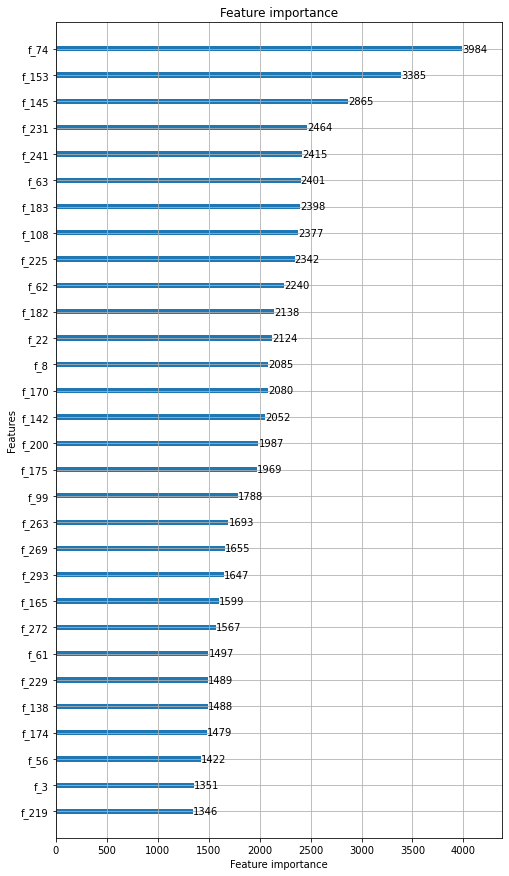

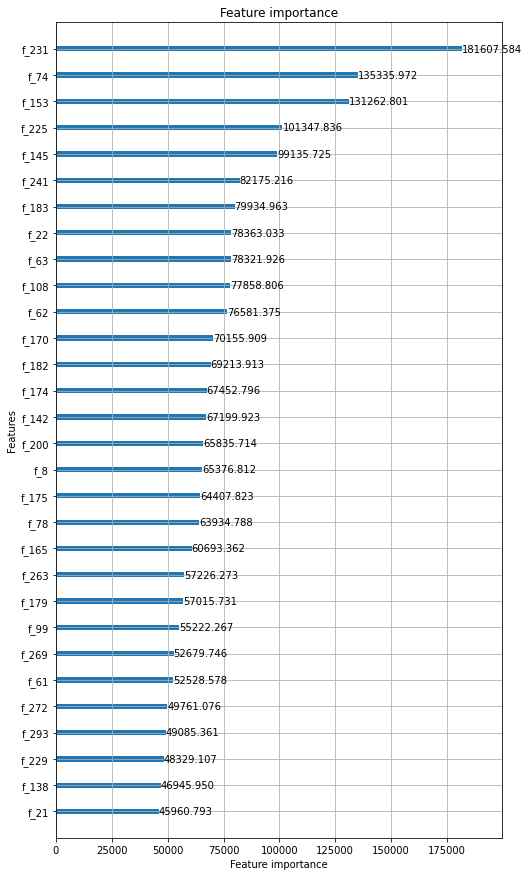

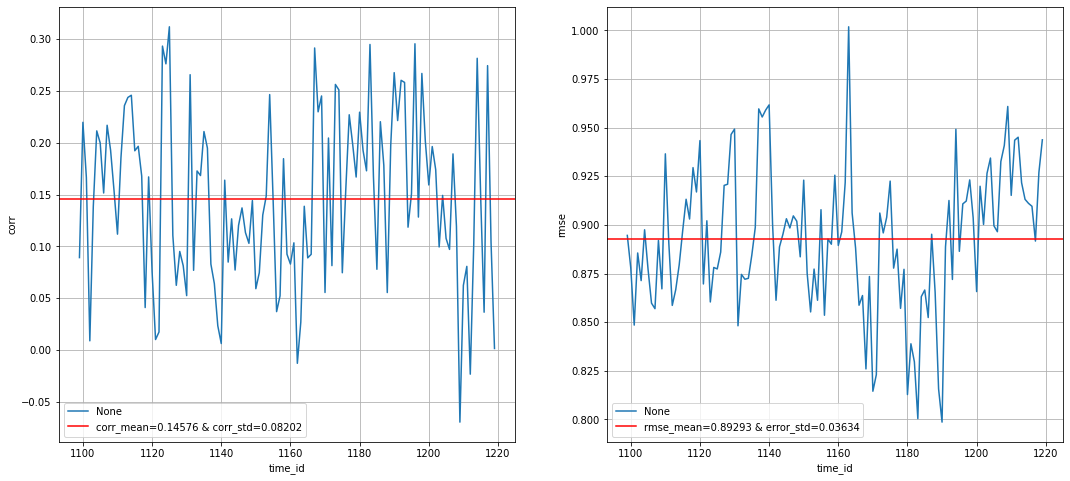

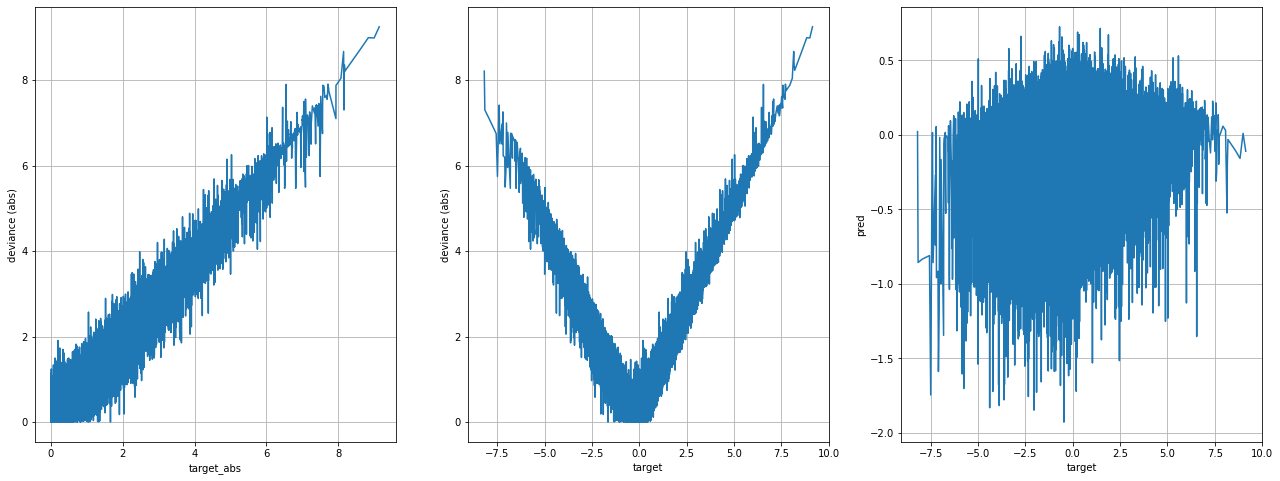

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's rmse: 0.905033	valid_0's pearsonr: 0.119856


[100]	valid_0's rmse: 0.904356	valid_0's pearsonr: 0.124939


[150]	valid_0's rmse: 0.903287	valid_0's pearsonr: 0.130427


[200]	valid_0's rmse: 0.902834	valid_0's pearsonr: 0.133774


[250]	valid_0's rmse: 0.902502	valid_0's pearsonr: 0.135669


[300]	valid_0's rmse: 0.902299	valid_0's pearsonr: 0.136669


[350]	valid_0's rmse: 0.901989	valid_0's pearsonr: 0.137988


[400]	valid_0's rmse: 0.90169	valid_0's pearsonr: 0.139734


[450]	valid_0's rmse: 0.901576	valid_0's pearsonr: 0.140268


[500]	valid_0's rmse: 0.901499	valid_0's pearsonr: 0.14086


[550]	valid_0's rmse: 0.901406	valid_0's pearsonr: 0.140803


[600]	valid_0's rmse: 0.901244	valid_0's pearsonr: 0.141637


[650]	valid_0's rmse: 0.901253	valid_0's pearsonr: 0.141809


[700]	valid_0's rmse: 0.901201	valid_0's pearsonr: 0.142151


[750]	valid_0's rmse: 0.901172	valid_0's pearsonr: 0.14213


[800]	valid_0's rmse: 0.901119	valid_0's pearsonr: 0.142274


[850]	valid_0's rmse: 0.901109	valid_0's pearsonr: 0.14251


[900]	valid_0's rmse: 0.90108	valid_0's pearsonr: 0.142433


[950]	valid_0's rmse: 0.901075	valid_0's pearsonr: 0.142103


[1000]	valid_0's rmse: 0.901043	valid_0's pearsonr: 0.142183


[1050]	valid_0's rmse: 0.901013	valid_0's pearsonr: 0.142179


[1100]	valid_0's rmse: 0.901012	valid_0's pearsonr: 0.142079


[1150]	valid_0's rmse: 0.900973	valid_0's pearsonr: 0.14232


[1200]	valid_0's rmse: 0.900941	valid_0's pearsonr: 0.142331


[1250]	valid_0's rmse: 0.90089	valid_0's pearsonr: 0.142585


[1300]	valid_0's rmse: 0.900864	valid_0's pearsonr: 0.142775


[1350]	valid_0's rmse: 0.900864	valid_0's pearsonr: 0.142761


[1400]	valid_0's rmse: 0.900812	valid_0's pearsonr: 0.143142


[1450]	valid_0's rmse: 0.900811	valid_0's pearsonr: 0.143147


[1500]	valid_0's rmse: 0.900801	valid_0's pearsonr: 0.143258


[1550]	valid_0's rmse: 0.900754	valid_0's pearsonr: 0.143591


[1600]	valid_0's rmse: 0.900756	valid_0's pearsonr: 0.143566


[1650]	valid_0's rmse: 0.900759	valid_0's pearsonr: 0.143572


[1700]	valid_0's rmse: 0.900787	valid_0's pearsonr: 0.143412


[1750]	valid_0's rmse: 0.900759	valid_0's pearsonr: 0.143624


[1800]	valid_0's rmse: 0.900766	valid_0's pearsonr: 0.143594


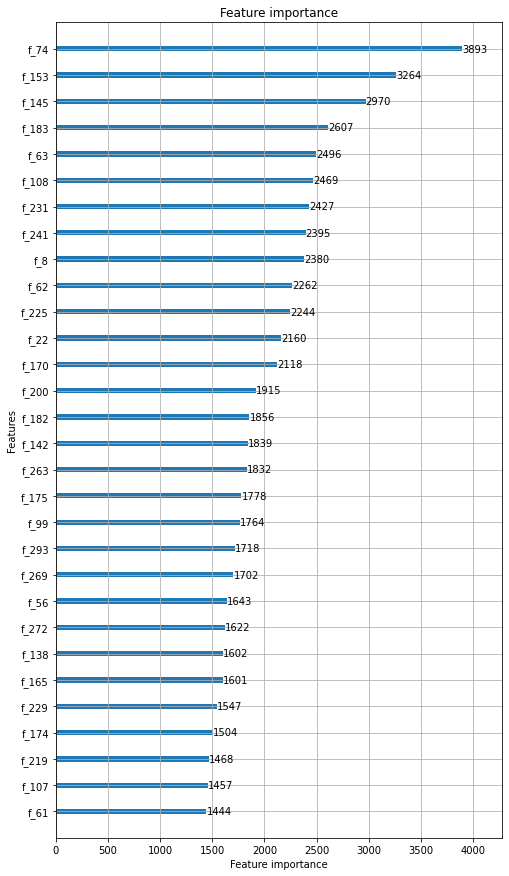

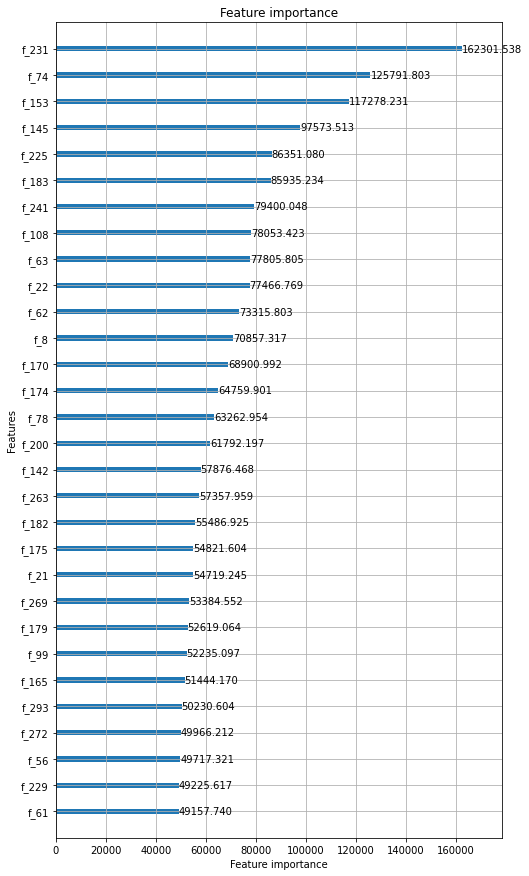

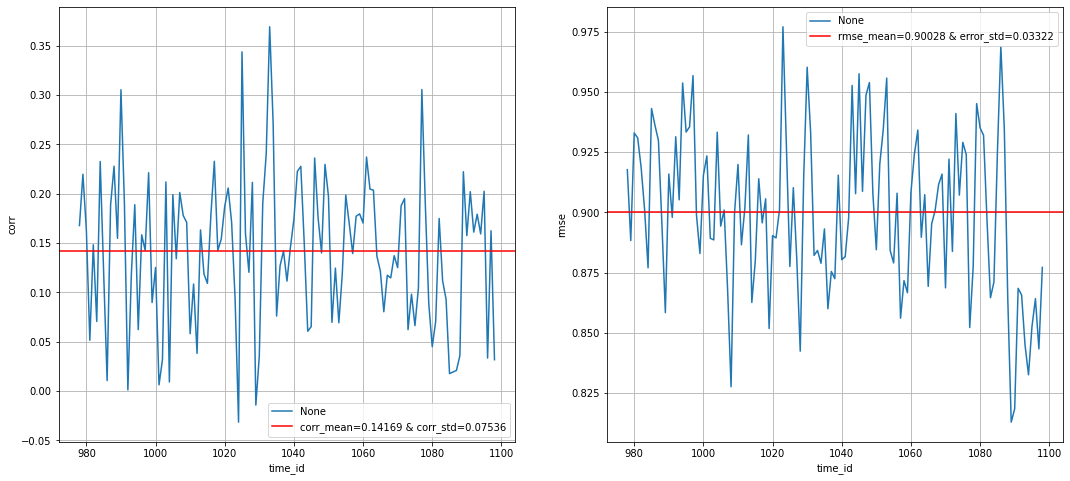

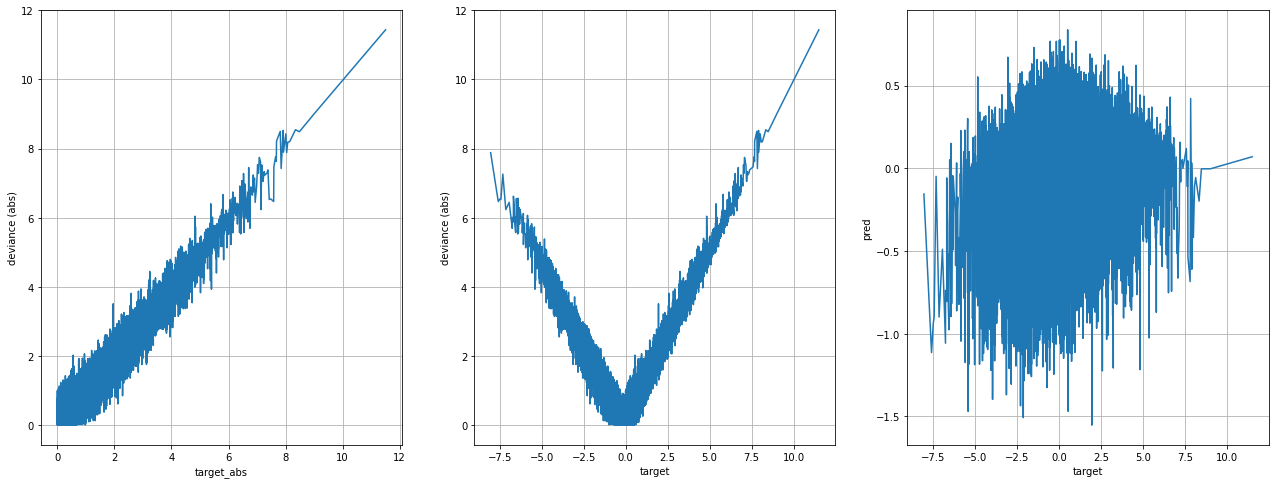

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's rmse: 0.939361	valid_0's pearsonr: 0.105529


[100]	valid_0's rmse: 0.938775	valid_0's pearsonr: 0.110051


[150]	valid_0's rmse: 0.937849	valid_0's pearsonr: 0.116039


[200]	valid_0's rmse: 0.93752	valid_0's pearsonr: 0.118775


[250]	valid_0's rmse: 0.937144	valid_0's pearsonr: 0.121573


[300]	valid_0's rmse: 0.936805	valid_0's pearsonr: 0.124407


[350]	valid_0's rmse: 0.936371	valid_0's pearsonr: 0.127549


[400]	valid_0's rmse: 0.936117	valid_0's pearsonr: 0.129286


[450]	valid_0's rmse: 0.935944	valid_0's pearsonr: 0.130643


[500]	valid_0's rmse: 0.935789	valid_0's pearsonr: 0.132057


[550]	valid_0's rmse: 0.935563	valid_0's pearsonr: 0.133438


[600]	valid_0's rmse: 0.935357	valid_0's pearsonr: 0.134897


[650]	valid_0's rmse: 0.935291	valid_0's pearsonr: 0.135582


[700]	valid_0's rmse: 0.935212	valid_0's pearsonr: 0.136154


[750]	valid_0's rmse: 0.935156	valid_0's pearsonr: 0.13647


[800]	valid_0's rmse: 0.935105	valid_0's pearsonr: 0.136645


[850]	valid_0's rmse: 0.935153	valid_0's pearsonr: 0.136337


[900]	valid_0's rmse: 0.935059	valid_0's pearsonr: 0.136817


[950]	valid_0's rmse: 0.934895	valid_0's pearsonr: 0.137934


[1000]	valid_0's rmse: 0.934917	valid_0's pearsonr: 0.13764


[1050]	valid_0's rmse: 0.934779	valid_0's pearsonr: 0.138624


[1100]	valid_0's rmse: 0.934758	valid_0's pearsonr: 0.138674


[1150]	valid_0's rmse: 0.934695	valid_0's pearsonr: 0.139121


[1200]	valid_0's rmse: 0.934591	valid_0's pearsonr: 0.139771


[1250]	valid_0's rmse: 0.934479	valid_0's pearsonr: 0.140555


[1300]	valid_0's rmse: 0.934431	valid_0's pearsonr: 0.140905


[1350]	valid_0's rmse: 0.93443	valid_0's pearsonr: 0.1409


[1400]	valid_0's rmse: 0.934366	valid_0's pearsonr: 0.14139


[1450]	valid_0's rmse: 0.934345	valid_0's pearsonr: 0.141566


[1500]	valid_0's rmse: 0.934311	valid_0's pearsonr: 0.141846


[1550]	valid_0's rmse: 0.934323	valid_0's pearsonr: 0.141766


[1600]	valid_0's rmse: 0.934246	valid_0's pearsonr: 0.142317


[1650]	valid_0's rmse: 0.93421	valid_0's pearsonr: 0.142631


[1700]	valid_0's rmse: 0.934209	valid_0's pearsonr: 0.142694


[1750]	valid_0's rmse: 0.934213	valid_0's pearsonr: 0.142692


[1800]	valid_0's rmse: 0.934198	valid_0's pearsonr: 0.142828


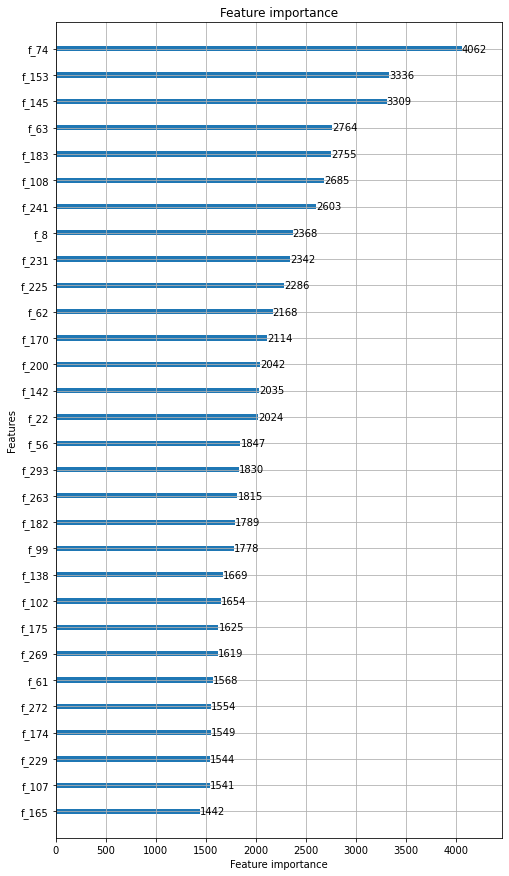

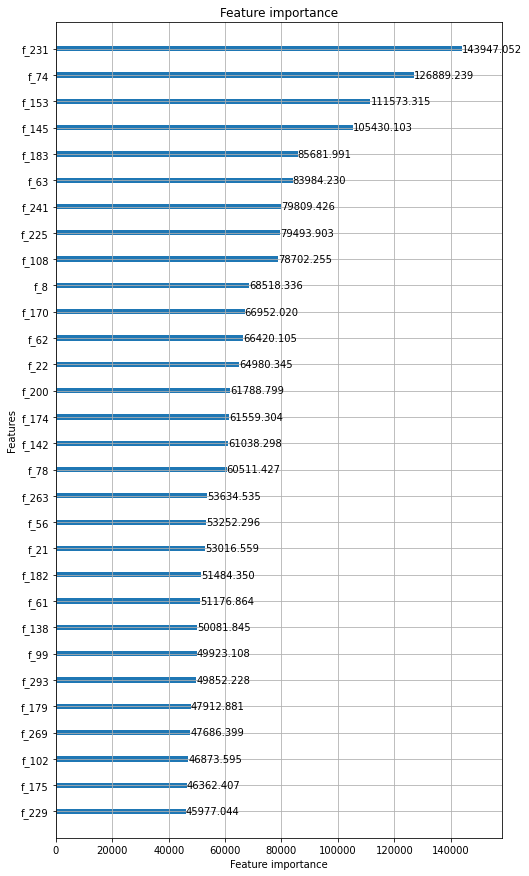

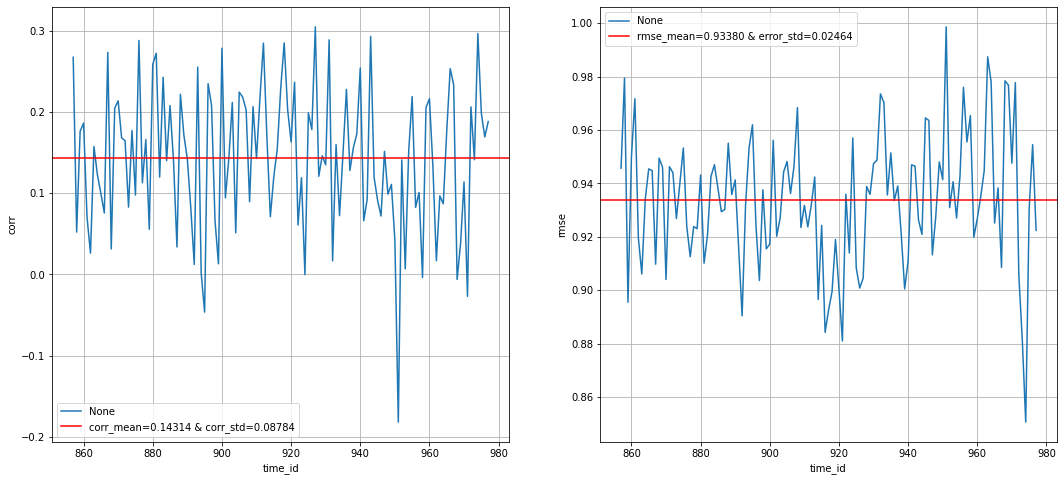

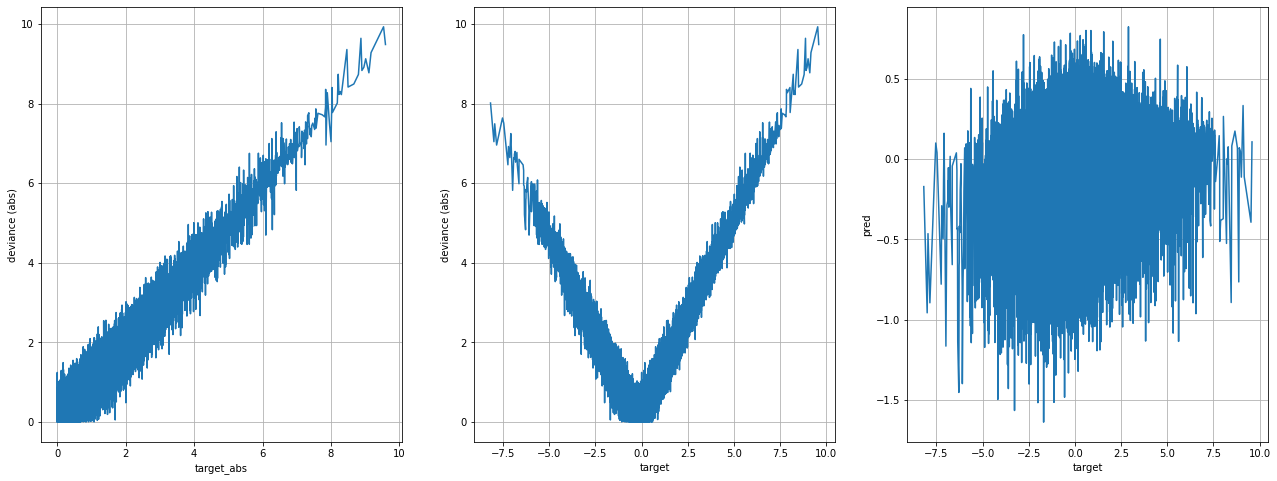

In [10]:
evaluate = True
metrics = {"corr_mean":list(), "corr_std":list(), "error_mean":list(), "error_std":list(),}

if evaluate:
    
    models = list()

    for train_idx,valid_idx in splits:

        train_dset = lgb.Dataset(
            data=features.loc[train_idx,:],
            label=target.loc[train_idx,"target"].values,
            free_raw_data=True
        )
        valid_dset = lgb.Dataset(
            data=features.loc[valid_idx,:],
            label=target.loc[valid_idx,"target"].values,
            free_raw_data=True
        )
        log_callback = lgb.log_evaluation(period=50,)

        model = lgb.train(
            params=model_params,
            train_set=train_dset,
            valid_sets=[valid_dset,],
            feval=pearsonr,
            callbacks=[log_callback],
        )
        models.append(model)

        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()
        
        # residual analysis on oof predictions
        oof = target.loc[valid_idx,:].copy()
        oof["time_id"] = time.loc[valid_idx,"time_id"]
        oof["pred"] = model.predict(features.loc[valid_idx,:])
        oof["target_abs"] = oof.eval("abs(target)")
        oof["dev"] = oof.eval("abs(target-pred)")

        corrs = oof.groupby("time_id").apply(lambda x: stats.pearsonr(x.target, x.pred)[0])
        corr_mean = corrs.mean()
        corr_std = corrs.std()
        error = oof.groupby("time_id").apply(lambda x: np.sqrt(np.mean((x.target-x.pred)**2)))
        error_mean = error.mean()
        error_std = error.std()
        
        metrics["corr_mean"].append(corr_mean)
        metrics["corr_std"].append(corr_std)
        metrics["error_mean"].append(error_mean)
        metrics["error_std"].append(error_std)

        plt.figure(figsize=(18,8))
        plt.subplot(1,2,1)
        corrs.plot()
        plt.axhline(
            y=corr_mean, 
            color='r', 
            linestyle='-', 
            label=f"corr_mean={corr_mean:.5f} & corr_std={corr_std:.5f}"
        )
        plt.grid()
        plt.ylabel("corr")
        plt.legend(loc="best")
        ##
        plt.subplot(1,2,2)
        error.plot()
        plt.axhline(
            y=error_mean, 
            color='r', 
            linestyle='-', 
            label=f"rmse_mean={error_mean:.5f} & error_std={error_std:.5f}"
        )
        plt.grid()
        plt.ylabel("rmse")
        plt.legend(loc="best")
        plt.show()

        plt.figure(figsize=(22,8))
        ##
        plt.subplot(1,3,1)
        plt.plot(oof.sort_values("target_abs").target_abs.values, oof.sort_values("target_abs").dev.values)
        plt.xlabel("target_abs")
        plt.ylabel("deviance (abs)")
        plt.grid()
        ##
        plt.subplot(1,3,2)
        plt.plot(oof.sort_values("target").target.values, oof.sort_values("target").dev.values)
        plt.xlabel("target")
        plt.ylabel("deviance (abs)")
        plt.grid()
        ##
        plt.subplot(1,3,3)
        plt.plot(oof.sort_values("target").target.values, oof.sort_values("target").pred.values)
        plt.xlabel("target")
        plt.ylabel("pred")
        plt.grid()
        plt.show()


In [11]:
metrics

{'corr_mean': [0.14575670914789704, 0.14168974921128002, 0.14314352206766037],
 'corr_std': [0.08201629823382636, 0.0753637494348294, 0.08783657494063278],
 'error_mean': [0.8929304977147248, 0.9002783423918753, 0.933804674833685],
 'error_std': [0.0363395066705113, 0.03321974090529744, 0.024642057740263387]}

In [12]:
# mean corr on validation
np.mean(metrics["corr_mean"])

0.14352999347561246

In [13]:
# mean rmse on validation
np.mean(metrics["error_mean"])

0.9090045049800951

***
## model training

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	training's rmse: 0.910397	training's pearsonr: 0.168915


[100]	training's rmse: 0.907711	training's pearsonr: 0.186666


[150]	training's rmse: 0.906275	training's pearsonr: 0.199049


[200]	training's rmse: 0.904691	training's pearsonr: 0.208173


[250]	training's rmse: 0.903443	training's pearsonr: 0.216249


[300]	training's rmse: 0.902805	training's pearsonr: 0.221138


[350]	training's rmse: 0.901215	training's pearsonr: 0.229596


[400]	training's rmse: 0.900493	training's pearsonr: 0.235547


[450]	training's rmse: 0.89937	training's pearsonr: 0.241904


[500]	training's rmse: 0.899067	training's pearsonr: 0.244493


[550]	training's rmse: 0.897139	training's pearsonr: 0.253532


[600]	training's rmse: 0.896021	training's pearsonr: 0.259887


[650]	training's rmse: 0.894516	training's pearsonr: 0.267613


[700]	training's rmse: 0.892892	training's pearsonr: 0.27519


[750]	training's rmse: 0.893272	training's pearsonr: 0.276862


[800]	training's rmse: 0.892588	training's pearsonr: 0.279812


[850]	training's rmse: 0.892079	training's pearsonr: 0.282959


[900]	training's rmse: 0.891244	training's pearsonr: 0.286637


[950]	training's rmse: 0.890054	training's pearsonr: 0.291678


[1000]	training's rmse: 0.888943	training's pearsonr: 0.29682


[1050]	training's rmse: 0.887676	training's pearsonr: 0.302633


[1100]	training's rmse: 0.88648	training's pearsonr: 0.3078


[1150]	training's rmse: 0.885031	training's pearsonr: 0.313778


[1200]	training's rmse: 0.88376	training's pearsonr: 0.31968


[1250]	training's rmse: 0.882791	training's pearsonr: 0.324447


[1300]	training's rmse: 0.882197	training's pearsonr: 0.327951


[1350]	training's rmse: 0.880966	training's pearsonr: 0.332653


[1400]	training's rmse: 0.880266	training's pearsonr: 0.336618


[1450]	training's rmse: 0.878979	training's pearsonr: 0.341385


[1500]	training's rmse: 0.878025	training's pearsonr: 0.345656


[1550]	training's rmse: 0.87729	training's pearsonr: 0.349398


[1600]	training's rmse: 0.876324	training's pearsonr: 0.352969


[1650]	training's rmse: 0.875129	training's pearsonr: 0.357416


[1700]	training's rmse: 0.87407	training's pearsonr: 0.361337


[1750]	training's rmse: 0.873042	training's pearsonr: 0.365299


[1800]	training's rmse: 0.872264	training's pearsonr: 0.368965


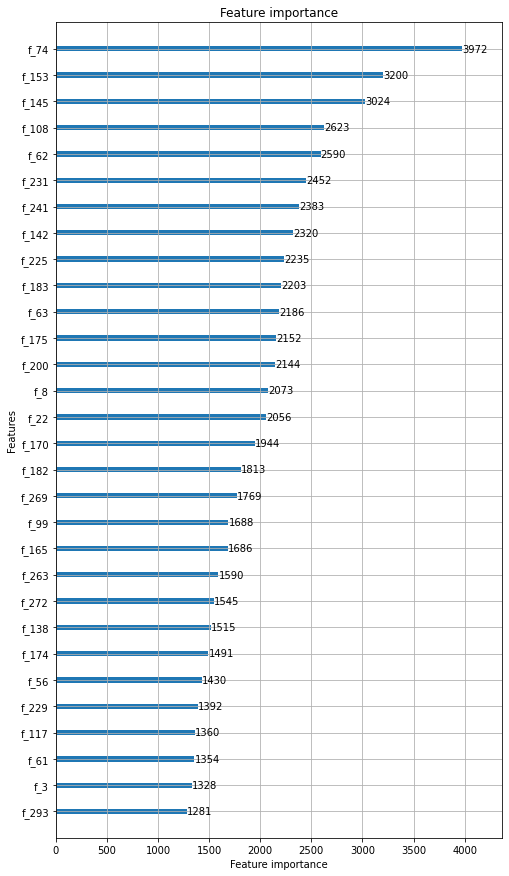

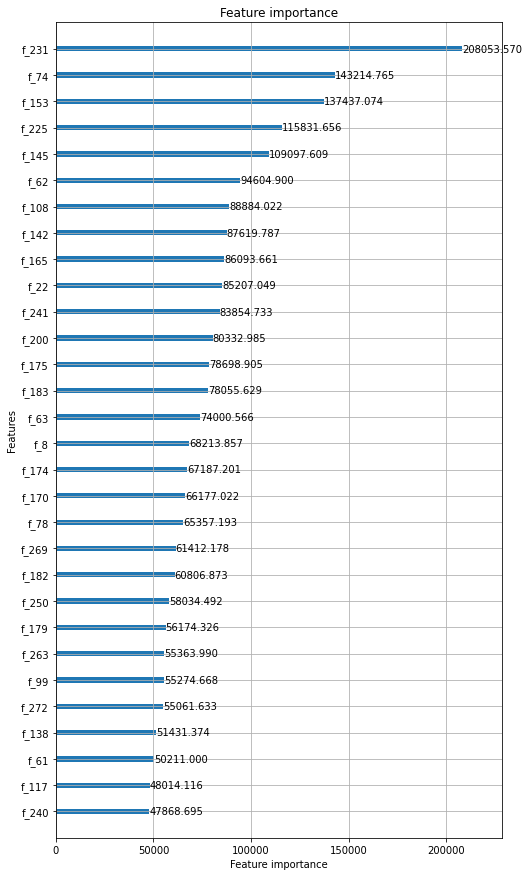

[50]	training's rmse: 0.909891	training's pearsonr: 0.171034


[100]	training's rmse: 0.906174	training's pearsonr: 0.193507


[150]	training's rmse: 0.905195	training's pearsonr: 0.205833


[200]	training's rmse: 0.902854	training's pearsonr: 0.217844


[250]	training's rmse: 0.901511	training's pearsonr: 0.22665


[300]	training's rmse: 0.900431	training's pearsonr: 0.234691


[350]	training's rmse: 0.89934	training's pearsonr: 0.241417


[400]	training's rmse: 0.8986	training's pearsonr: 0.246179


[450]	training's rmse: 0.897445	training's pearsonr: 0.251922


[500]	training's rmse: 0.896355	training's pearsonr: 0.258047


[550]	training's rmse: 0.894945	training's pearsonr: 0.265215


[600]	training's rmse: 0.893179	training's pearsonr: 0.273649


[650]	training's rmse: 0.8918	training's pearsonr: 0.280957


[700]	training's rmse: 0.890229	training's pearsonr: 0.288459


[750]	training's rmse: 0.889491	training's pearsonr: 0.293414


[800]	training's rmse: 0.888772	training's pearsonr: 0.297643


[850]	training's rmse: 0.888198	training's pearsonr: 0.300945


[900]	training's rmse: 0.887644	training's pearsonr: 0.304463


[950]	training's rmse: 0.887357	training's pearsonr: 0.306463


[1000]	training's rmse: 0.886548	training's pearsonr: 0.309751


[1050]	training's rmse: 0.885745	training's pearsonr: 0.31336


[1100]	training's rmse: 0.884729	training's pearsonr: 0.317263


[1150]	training's rmse: 0.883651	training's pearsonr: 0.32211


[1200]	training's rmse: 0.882893	training's pearsonr: 0.325782


[1250]	training's rmse: 0.881993	training's pearsonr: 0.329669


[1300]	training's rmse: 0.881054	training's pearsonr: 0.333334


[1350]	training's rmse: 0.880492	training's pearsonr: 0.336827


[1400]	training's rmse: 0.879819	training's pearsonr: 0.339911


[1450]	training's rmse: 0.878581	training's pearsonr: 0.344126


[1500]	training's rmse: 0.87804	training's pearsonr: 0.347054


[1550]	training's rmse: 0.87671	training's pearsonr: 0.351775


[1600]	training's rmse: 0.875891	training's pearsonr: 0.355256


[1650]	training's rmse: 0.875059	training's pearsonr: 0.358802


[1700]	training's rmse: 0.874545	training's pearsonr: 0.361407


[1750]	training's rmse: 0.87386	training's pearsonr: 0.364355


[1800]	training's rmse: 0.872953	training's pearsonr: 0.36767


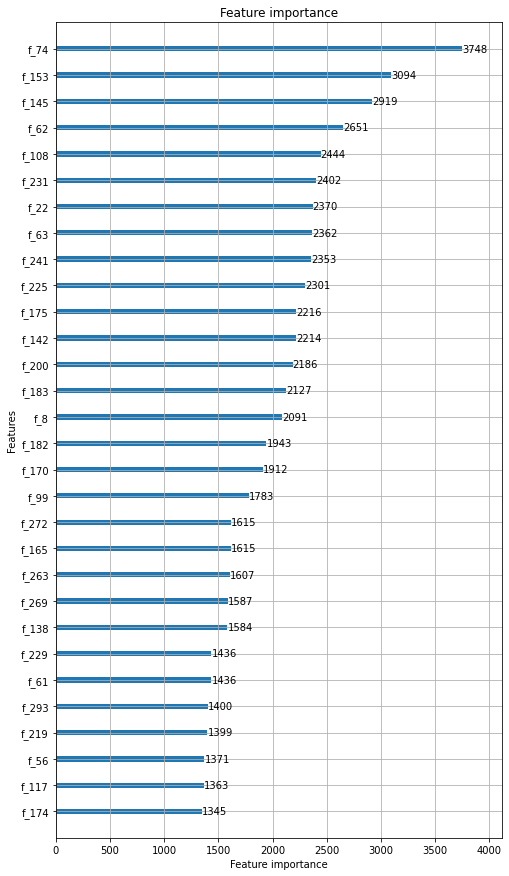

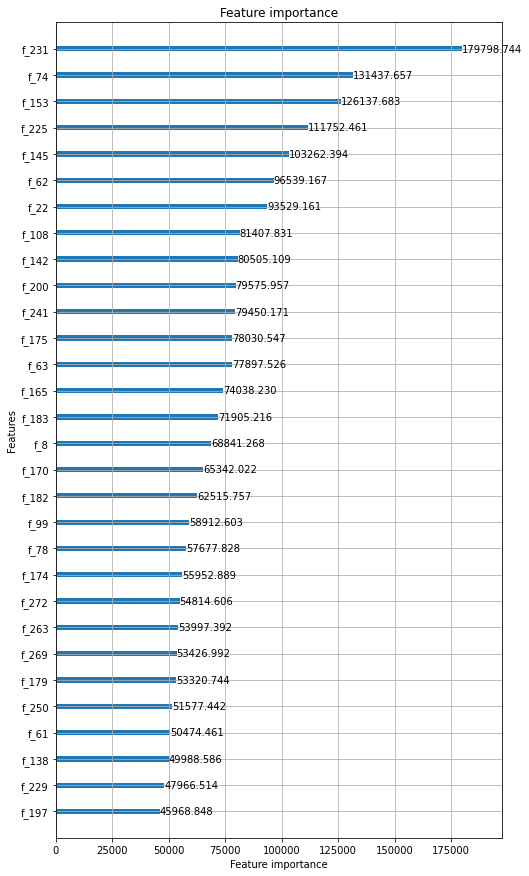

[50]	training's rmse: 0.910814	training's pearsonr: 0.168217


[100]	training's rmse: 0.907827	training's pearsonr: 0.18567


[150]	training's rmse: 0.905441	training's pearsonr: 0.201297


[200]	training's rmse: 0.903389	training's pearsonr: 0.214449


[250]	training's rmse: 0.902571	training's pearsonr: 0.222042


[300]	training's rmse: 0.901567	training's pearsonr: 0.228133


[350]	training's rmse: 0.900136	training's pearsonr: 0.235621


[400]	training's rmse: 0.900137	training's pearsonr: 0.238597


[450]	training's rmse: 0.899011	training's pearsonr: 0.244383


[500]	training's rmse: 0.897851	training's pearsonr: 0.249793


[550]	training's rmse: 0.896357	training's pearsonr: 0.257588


[600]	training's rmse: 0.895344	training's pearsonr: 0.263524


[650]	training's rmse: 0.894015	training's pearsonr: 0.270047


[700]	training's rmse: 0.89284	training's pearsonr: 0.276146


[750]	training's rmse: 0.891286	training's pearsonr: 0.283525


[800]	training's rmse: 0.890665	training's pearsonr: 0.288185


[850]	training's rmse: 0.889887	training's pearsonr: 0.292519


[900]	training's rmse: 0.889163	training's pearsonr: 0.296261


[950]	training's rmse: 0.888732	training's pearsonr: 0.299293


[1000]	training's rmse: 0.887918	training's pearsonr: 0.302582


[1050]	training's rmse: 0.887618	training's pearsonr: 0.305207


[1100]	training's rmse: 0.886265	training's pearsonr: 0.309982


[1150]	training's rmse: 0.885067	training's pearsonr: 0.315133


[1200]	training's rmse: 0.884303	training's pearsonr: 0.318986


[1250]	training's rmse: 0.883305	training's pearsonr: 0.323436


[1300]	training's rmse: 0.882286	training's pearsonr: 0.327864


[1350]	training's rmse: 0.881184	training's pearsonr: 0.332195


[1400]	training's rmse: 0.880096	training's pearsonr: 0.336923


[1450]	training's rmse: 0.879458	training's pearsonr: 0.340347


[1500]	training's rmse: 0.879076	training's pearsonr: 0.342938


[1550]	training's rmse: 0.878451	training's pearsonr: 0.345989


[1600]	training's rmse: 0.877552	training's pearsonr: 0.349107


[1650]	training's rmse: 0.87687	training's pearsonr: 0.351826


[1700]	training's rmse: 0.875683	training's pearsonr: 0.356009


[1750]	training's rmse: 0.875424	training's pearsonr: 0.358363


[1800]	training's rmse: 0.87467	training's pearsonr: 0.361344


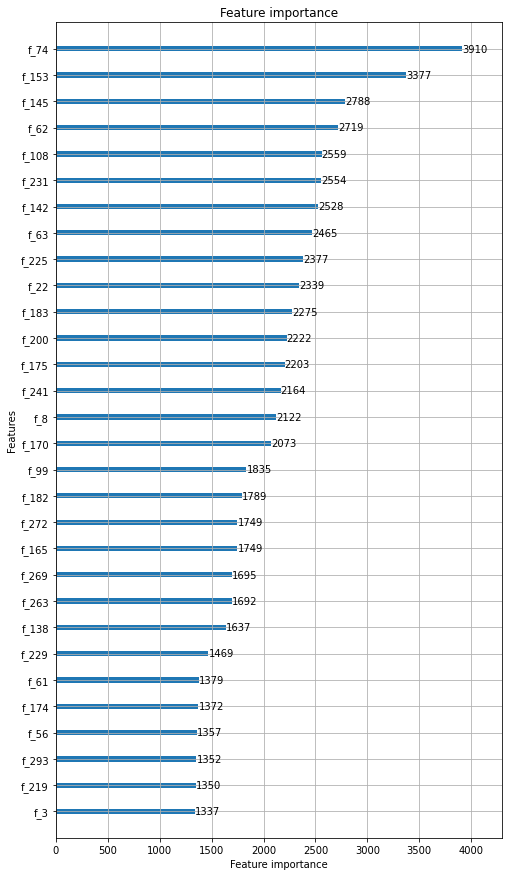

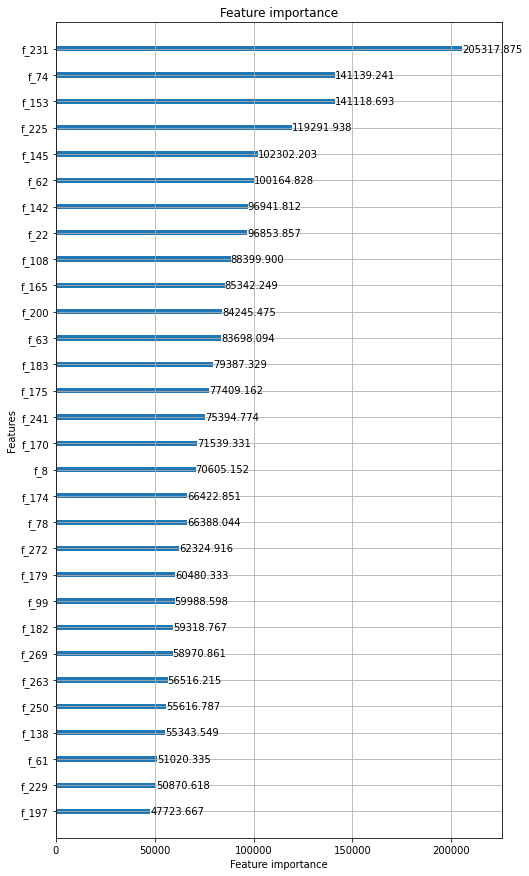

[50]	training's rmse: 0.910725	training's pearsonr: 0.168879


[100]	training's rmse: 0.908243	training's pearsonr: 0.186125


[150]	training's rmse: 0.906058	training's pearsonr: 0.198731


[200]	training's rmse: 0.904012	training's pearsonr: 0.211083


[250]	training's rmse: 0.903112	training's pearsonr: 0.2193


[300]	training's rmse: 0.902336	training's pearsonr: 0.224729


[350]	training's rmse: 0.900661	training's pearsonr: 0.232514


[400]	training's rmse: 0.899535	training's pearsonr: 0.239408


[450]	training's rmse: 0.898377	training's pearsonr: 0.246303


[500]	training's rmse: 0.897239	training's pearsonr: 0.253056


[550]	training's rmse: 0.895996	training's pearsonr: 0.259634


[600]	training's rmse: 0.89548	training's pearsonr: 0.263269


[650]	training's rmse: 0.894986	training's pearsonr: 0.26712


[700]	training's rmse: 0.893789	training's pearsonr: 0.272231


[750]	training's rmse: 0.893096	training's pearsonr: 0.276315


[800]	training's rmse: 0.892199	training's pearsonr: 0.281286


[850]	training's rmse: 0.891775	training's pearsonr: 0.284227


[900]	training's rmse: 0.891081	training's pearsonr: 0.287619


[950]	training's rmse: 0.890452	training's pearsonr: 0.291242


[1000]	training's rmse: 0.889638	training's pearsonr: 0.295064


[1050]	training's rmse: 0.888768	training's pearsonr: 0.298903


[1100]	training's rmse: 0.887504	training's pearsonr: 0.304015


[1150]	training's rmse: 0.886407	training's pearsonr: 0.309201


[1200]	training's rmse: 0.885513	training's pearsonr: 0.313735


[1250]	training's rmse: 0.884491	training's pearsonr: 0.318211


[1300]	training's rmse: 0.883238	training's pearsonr: 0.323041


[1350]	training's rmse: 0.882728	training's pearsonr: 0.326283


[1400]	training's rmse: 0.88208	training's pearsonr: 0.329491


[1450]	training's rmse: 0.881374	training's pearsonr: 0.332695


[1500]	training's rmse: 0.879732	training's pearsonr: 0.337995


[1550]	training's rmse: 0.878872	training's pearsonr: 0.341914


[1600]	training's rmse: 0.877992	training's pearsonr: 0.34572


[1650]	training's rmse: 0.877203	training's pearsonr: 0.349307


[1700]	training's rmse: 0.876318	training's pearsonr: 0.352982


[1750]	training's rmse: 0.875447	training's pearsonr: 0.356754


[1800]	training's rmse: 0.874978	training's pearsonr: 0.35967


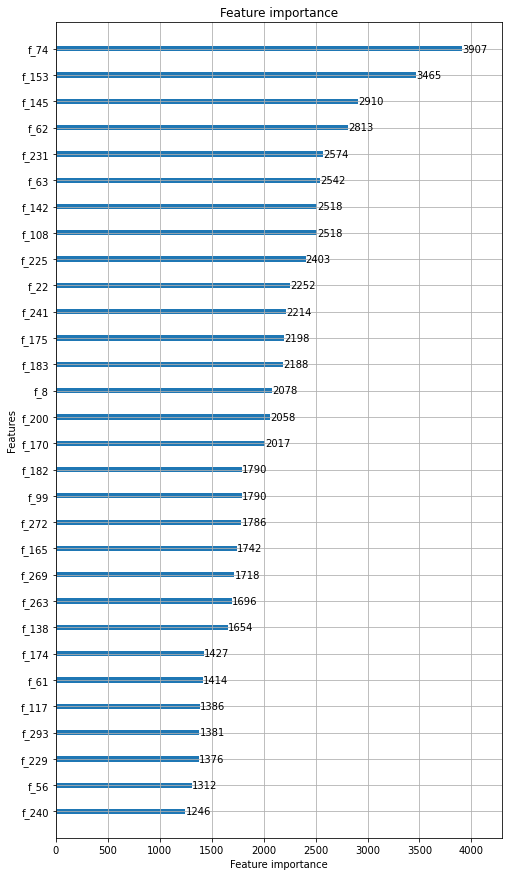

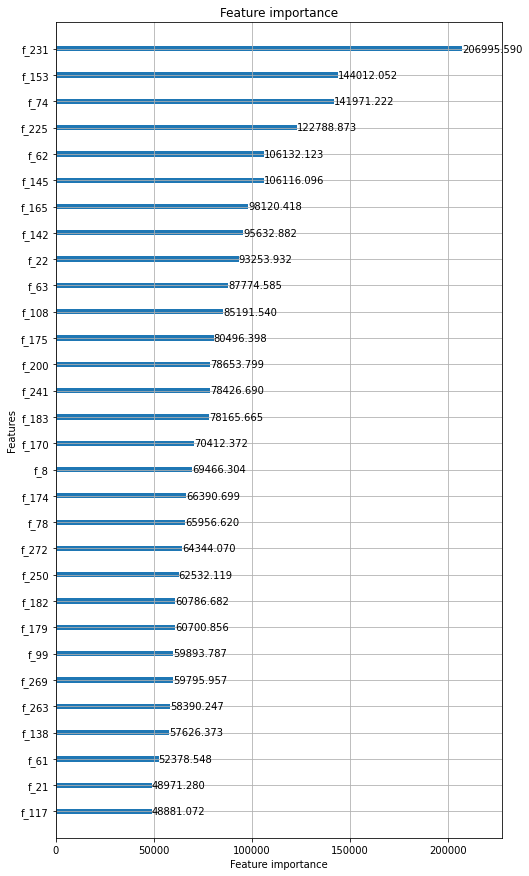

[50]	training's rmse: 0.911519	training's pearsonr: 0.165365


[100]	training's rmse: 0.909191	training's pearsonr: 0.179473


[150]	training's rmse: 0.907479	training's pearsonr: 0.190102


[200]	training's rmse: 0.90588	training's pearsonr: 0.200566


[250]	training's rmse: 0.904963	training's pearsonr: 0.206297


[300]	training's rmse: 0.903014	training's pearsonr: 0.216444


[350]	training's rmse: 0.901756	training's pearsonr: 0.225654


[400]	training's rmse: 0.90061	training's pearsonr: 0.23318


[450]	training's rmse: 0.899627	training's pearsonr: 0.238833


[500]	training's rmse: 0.899027	training's pearsonr: 0.242945


[550]	training's rmse: 0.897372	training's pearsonr: 0.250936


[600]	training's rmse: 0.896156	training's pearsonr: 0.257972


[650]	training's rmse: 0.895549	training's pearsonr: 0.262389


[700]	training's rmse: 0.894771	training's pearsonr: 0.266423


[750]	training's rmse: 0.894619	training's pearsonr: 0.269373


[800]	training's rmse: 0.894367	training's pearsonr: 0.271461


[850]	training's rmse: 0.893382	training's pearsonr: 0.275623


[900]	training's rmse: 0.892795	training's pearsonr: 0.278765


[950]	training's rmse: 0.891928	training's pearsonr: 0.282985


[1000]	training's rmse: 0.890646	training's pearsonr: 0.288559


[1050]	training's rmse: 0.889278	training's pearsonr: 0.294895


[1100]	training's rmse: 0.888987	training's pearsonr: 0.298094


[1150]	training's rmse: 0.887844	training's pearsonr: 0.302617


[1200]	training's rmse: 0.886554	training's pearsonr: 0.308042


[1250]	training's rmse: 0.885432	training's pearsonr: 0.313248


[1300]	training's rmse: 0.884921	training's pearsonr: 0.316484


[1350]	training's rmse: 0.883915	training's pearsonr: 0.320726


[1400]	training's rmse: 0.883114	training's pearsonr: 0.324352


[1450]	training's rmse: 0.881744	training's pearsonr: 0.329481


[1500]	training's rmse: 0.880579	training's pearsonr: 0.334362


[1550]	training's rmse: 0.879488	training's pearsonr: 0.3389


[1600]	training's rmse: 0.878945	training's pearsonr: 0.342195


[1650]	training's rmse: 0.877709	training's pearsonr: 0.346627


[1700]	training's rmse: 0.876879	training's pearsonr: 0.350415


[1750]	training's rmse: 0.875993	training's pearsonr: 0.35423


[1800]	training's rmse: 0.874792	training's pearsonr: 0.358311


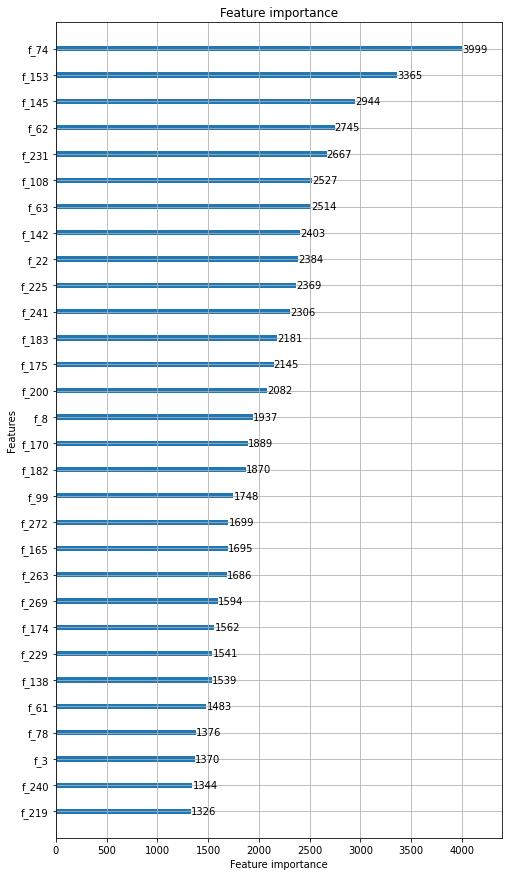

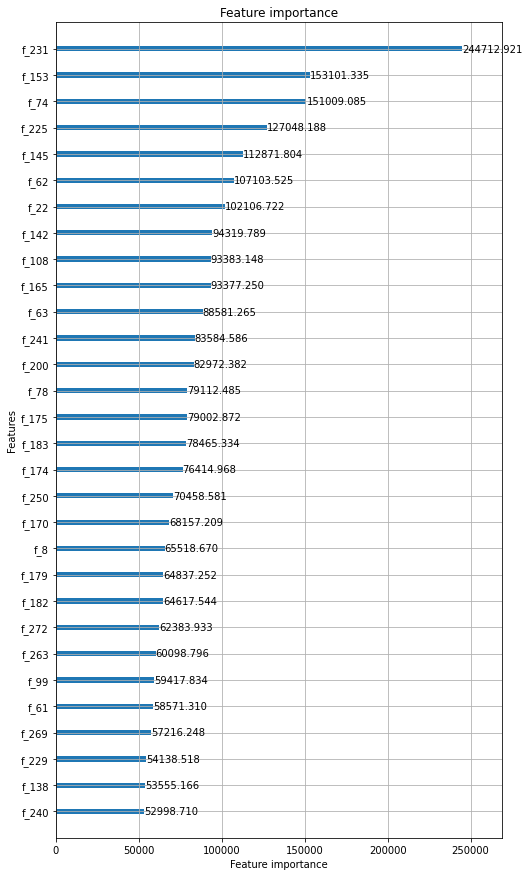

[50]	training's rmse: 0.910959	training's pearsonr: 0.168505


[100]	training's rmse: 0.907758	training's pearsonr: 0.186119


[150]	training's rmse: 0.906133	training's pearsonr: 0.198174


[200]	training's rmse: 0.905502	training's pearsonr: 0.204709


[250]	training's rmse: 0.903794	training's pearsonr: 0.213378


[300]	training's rmse: 0.902525	training's pearsonr: 0.221835


[350]	training's rmse: 0.901732	training's pearsonr: 0.227599


[400]	training's rmse: 0.900148	training's pearsonr: 0.235553


[450]	training's rmse: 0.899121	training's pearsonr: 0.242662


[500]	training's rmse: 0.897765	training's pearsonr: 0.250421


[550]	training's rmse: 0.897048	training's pearsonr: 0.254692


[600]	training's rmse: 0.895561	training's pearsonr: 0.261501


[650]	training's rmse: 0.894891	training's pearsonr: 0.26647


[700]	training's rmse: 0.894201	training's pearsonr: 0.270475


[750]	training's rmse: 0.892975	training's pearsonr: 0.275863


[800]	training's rmse: 0.892192	training's pearsonr: 0.280699


[850]	training's rmse: 0.891731	training's pearsonr: 0.283979


[900]	training's rmse: 0.890298	training's pearsonr: 0.289592


[950]	training's rmse: 0.889319	training's pearsonr: 0.294572


[1000]	training's rmse: 0.888571	training's pearsonr: 0.29867


[1050]	training's rmse: 0.887286	training's pearsonr: 0.303901


[1100]	training's rmse: 0.88638	training's pearsonr: 0.30881


[1150]	training's rmse: 0.885214	training's pearsonr: 0.313851


[1200]	training's rmse: 0.8847	training's pearsonr: 0.317133


[1250]	training's rmse: 0.883477	training's pearsonr: 0.322112


[1300]	training's rmse: 0.882657	training's pearsonr: 0.326272


[1350]	training's rmse: 0.88214	training's pearsonr: 0.329253


[1400]	training's rmse: 0.881155	training's pearsonr: 0.333462


[1450]	training's rmse: 0.880664	training's pearsonr: 0.33656


[1500]	training's rmse: 0.879763	training's pearsonr: 0.339827


[1550]	training's rmse: 0.879063	training's pearsonr: 0.343003


[1600]	training's rmse: 0.877842	training's pearsonr: 0.347148


[1650]	training's rmse: 0.876959	training's pearsonr: 0.35089


[1700]	training's rmse: 0.876413	training's pearsonr: 0.354028


[1750]	training's rmse: 0.875543	training's pearsonr: 0.357281


[1800]	training's rmse: 0.874389	training's pearsonr: 0.361338


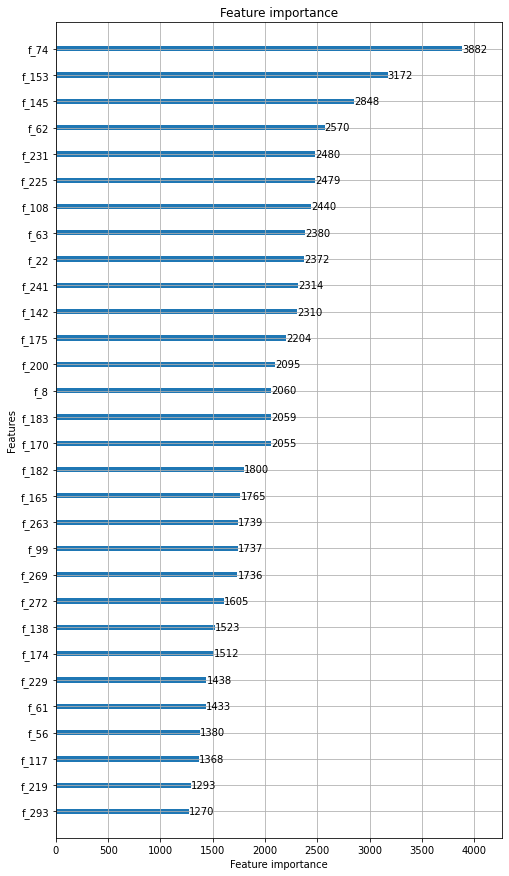

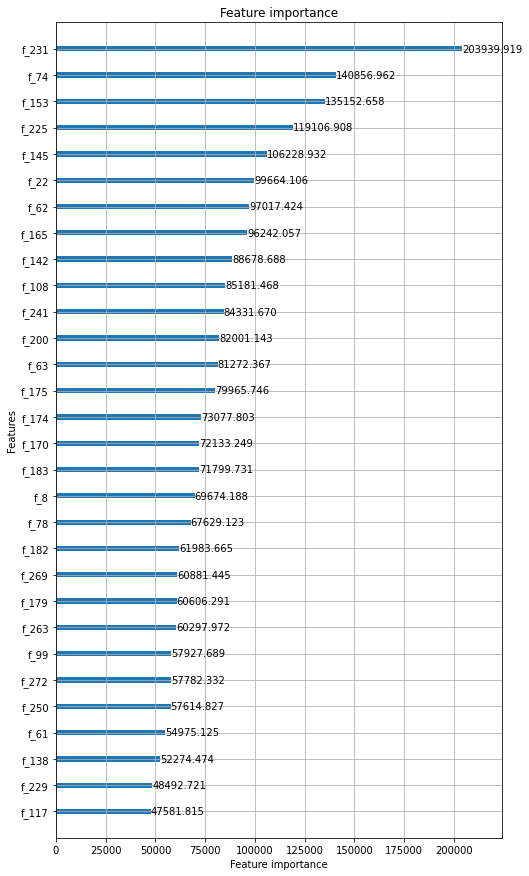

[50]	training's rmse: 0.910288	training's pearsonr: 0.16864


[100]	training's rmse: 0.907672	training's pearsonr: 0.187167


[150]	training's rmse: 0.906229	training's pearsonr: 0.199029


[200]	training's rmse: 0.904066	training's pearsonr: 0.209858


[250]	training's rmse: 0.902311	training's pearsonr: 0.220994


[300]	training's rmse: 0.901448	training's pearsonr: 0.227979


[350]	training's rmse: 0.900981	training's pearsonr: 0.232934


[400]	training's rmse: 0.899831	training's pearsonr: 0.2384


[450]	training's rmse: 0.898531	training's pearsonr: 0.245522


[500]	training's rmse: 0.896927	training's pearsonr: 0.253579


[550]	training's rmse: 0.896187	training's pearsonr: 0.259178


[600]	training's rmse: 0.895593	training's pearsonr: 0.262833


[650]	training's rmse: 0.89435	training's pearsonr: 0.268669


[700]	training's rmse: 0.893593	training's pearsonr: 0.273426


[750]	training's rmse: 0.893426	training's pearsonr: 0.276177


[800]	training's rmse: 0.892455	training's pearsonr: 0.280324


[850]	training's rmse: 0.89177	training's pearsonr: 0.284386


[900]	training's rmse: 0.890221	training's pearsonr: 0.290349


[950]	training's rmse: 0.889333	training's pearsonr: 0.295215


[1000]	training's rmse: 0.888645	training's pearsonr: 0.298965


[1050]	training's rmse: 0.888428	training's pearsonr: 0.301521


[1100]	training's rmse: 0.887205	training's pearsonr: 0.306314


[1150]	training's rmse: 0.886093	training's pearsonr: 0.310672


[1200]	training's rmse: 0.885117	training's pearsonr: 0.315046


[1250]	training's rmse: 0.884638	training's pearsonr: 0.317938


[1300]	training's rmse: 0.883422	training's pearsonr: 0.322655


[1350]	training's rmse: 0.882717	training's pearsonr: 0.326204


[1400]	training's rmse: 0.882064	training's pearsonr: 0.329365


[1450]	training's rmse: 0.881927	training's pearsonr: 0.331647


[1500]	training's rmse: 0.880793	training's pearsonr: 0.335174


[1550]	training's rmse: 0.880283	training's pearsonr: 0.338002


[1600]	training's rmse: 0.879471	training's pearsonr: 0.341408


[1650]	training's rmse: 0.878482	training's pearsonr: 0.345011


[1700]	training's rmse: 0.877708	training's pearsonr: 0.348252


[1750]	training's rmse: 0.877176	training's pearsonr: 0.351031


[1800]	training's rmse: 0.87595	training's pearsonr: 0.354928


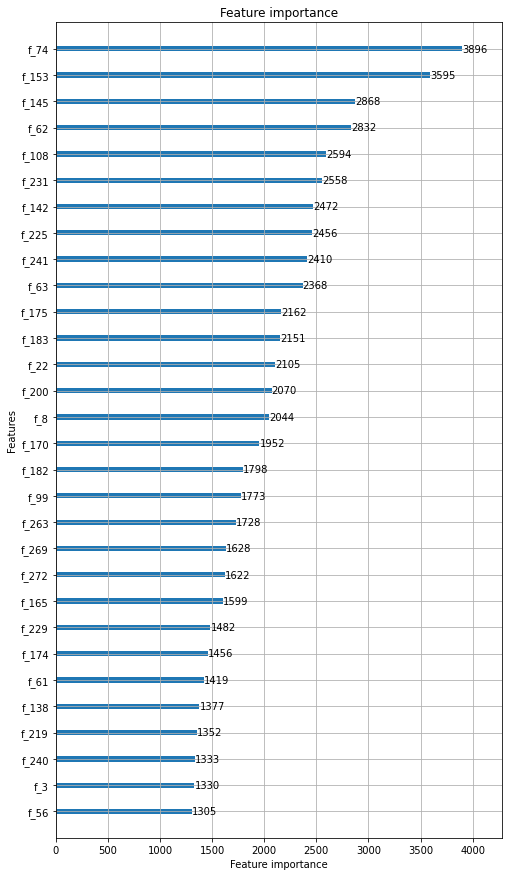

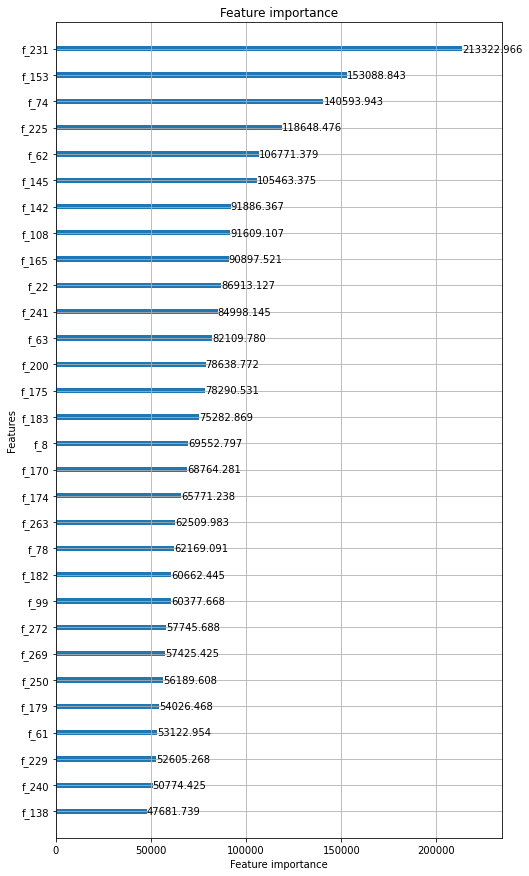

[50]	training's rmse: 0.910469	training's pearsonr: 0.168785


[100]	training's rmse: 0.908051	training's pearsonr: 0.186344


[150]	training's rmse: 0.906113	training's pearsonr: 0.197426


[200]	training's rmse: 0.904589	training's pearsonr: 0.208989


[250]	training's rmse: 0.903328	training's pearsonr: 0.217632


[300]	training's rmse: 0.902643	training's pearsonr: 0.223707


[350]	training's rmse: 0.901449	training's pearsonr: 0.229575


[400]	training's rmse: 0.90037	training's pearsonr: 0.23576


[450]	training's rmse: 0.899372	training's pearsonr: 0.2415


[500]	training's rmse: 0.898456	training's pearsonr: 0.246715


[550]	training's rmse: 0.897642	training's pearsonr: 0.25125


[600]	training's rmse: 0.895878	training's pearsonr: 0.259474


[650]	training's rmse: 0.895175	training's pearsonr: 0.264815


[700]	training's rmse: 0.894762	training's pearsonr: 0.267875


[750]	training's rmse: 0.894528	training's pearsonr: 0.270594


[800]	training's rmse: 0.893235	training's pearsonr: 0.275681


[850]	training's rmse: 0.891723	training's pearsonr: 0.28251


[900]	training's rmse: 0.890567	training's pearsonr: 0.288104


[950]	training's rmse: 0.88998	training's pearsonr: 0.292594


[1000]	training's rmse: 0.889266	training's pearsonr: 0.296186


[1050]	training's rmse: 0.887976	training's pearsonr: 0.301376


[1100]	training's rmse: 0.887214	training's pearsonr: 0.305526


[1150]	training's rmse: 0.886694	training's pearsonr: 0.309079


[1200]	training's rmse: 0.886	training's pearsonr: 0.312078


[1250]	training's rmse: 0.884518	training's pearsonr: 0.31729


[1300]	training's rmse: 0.88346	training's pearsonr: 0.322072


[1350]	training's rmse: 0.882283	training's pearsonr: 0.327025


[1400]	training's rmse: 0.881781	training's pearsonr: 0.330275


[1450]	training's rmse: 0.880449	training's pearsonr: 0.335175


[1500]	training's rmse: 0.879762	training's pearsonr: 0.338594


[1550]	training's rmse: 0.879008	training's pearsonr: 0.34207


[1600]	training's rmse: 0.877874	training's pearsonr: 0.346189


[1650]	training's rmse: 0.877208	training's pearsonr: 0.349655


[1700]	training's rmse: 0.876381	training's pearsonr: 0.353157


[1750]	training's rmse: 0.875231	training's pearsonr: 0.357591


[1800]	training's rmse: 0.874508	training's pearsonr: 0.360676


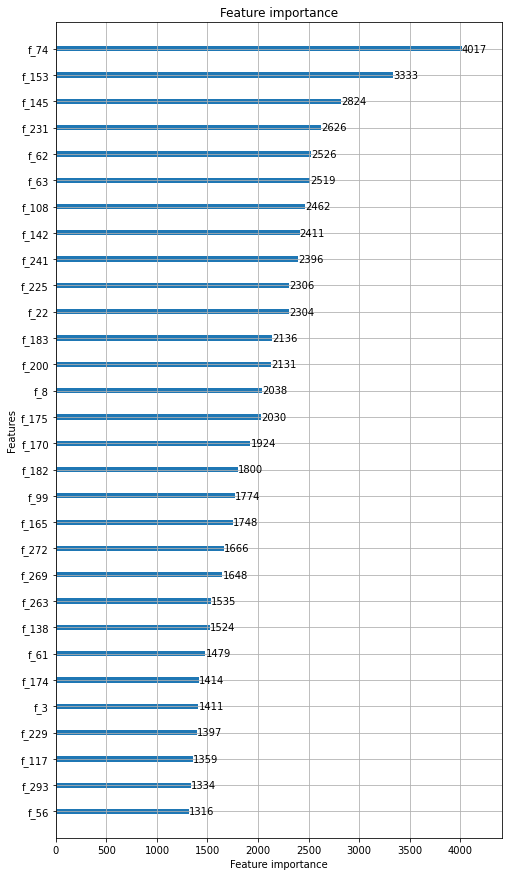

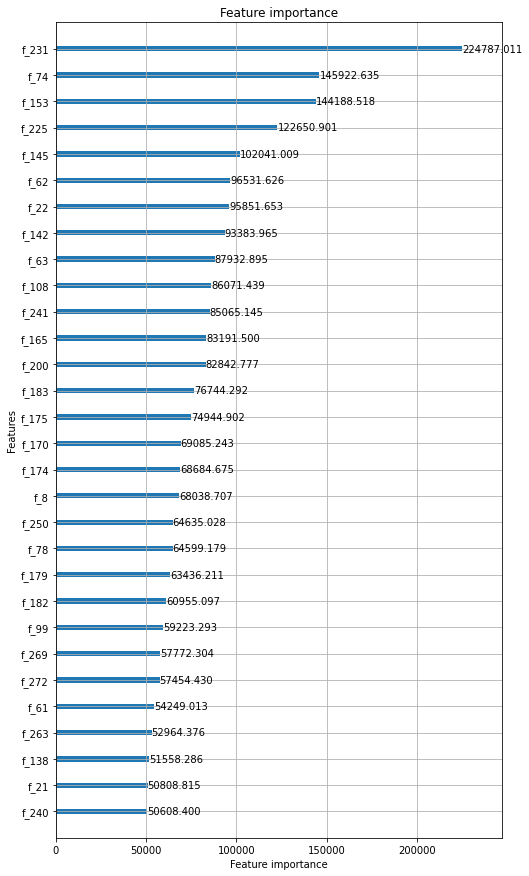

[50]	training's rmse: 0.911112	training's pearsonr: 0.166967


[100]	training's rmse: 0.909226	training's pearsonr: 0.179443


[150]	training's rmse: 0.906794	training's pearsonr: 0.194548


[200]	training's rmse: 0.905081	training's pearsonr: 0.204347


[250]	training's rmse: 0.904366	training's pearsonr: 0.210698


[300]	training's rmse: 0.902365	training's pearsonr: 0.221512


[350]	training's rmse: 0.90123	training's pearsonr: 0.22964


[400]	training's rmse: 0.90042	training's pearsonr: 0.23582


[450]	training's rmse: 0.899413	training's pearsonr: 0.241544


[500]	training's rmse: 0.898857	training's pearsonr: 0.245735


[550]	training's rmse: 0.897863	training's pearsonr: 0.25098


[600]	training's rmse: 0.897475	training's pearsonr: 0.254177


[650]	training's rmse: 0.89646	training's pearsonr: 0.258979


[700]	training's rmse: 0.895242	training's pearsonr: 0.264512


[750]	training's rmse: 0.893472	training's pearsonr: 0.272674


[800]	training's rmse: 0.89278	training's pearsonr: 0.277256


[850]	training's rmse: 0.892146	training's pearsonr: 0.281359


[900]	training's rmse: 0.891542	training's pearsonr: 0.284671


[950]	training's rmse: 0.890287	training's pearsonr: 0.290119


[1000]	training's rmse: 0.889345	training's pearsonr: 0.295033


[1050]	training's rmse: 0.888773	training's pearsonr: 0.298821


[1100]	training's rmse: 0.888028	training's pearsonr: 0.301914


[1150]	training's rmse: 0.887419	training's pearsonr: 0.30528


[1200]	training's rmse: 0.885956	training's pearsonr: 0.311003


[1250]	training's rmse: 0.885209	training's pearsonr: 0.315037


[1300]	training's rmse: 0.884144	training's pearsonr: 0.319635


[1350]	training's rmse: 0.883836	training's pearsonr: 0.322045


[1400]	training's rmse: 0.883242	training's pearsonr: 0.324904


[1450]	training's rmse: 0.881559	training's pearsonr: 0.33009


[1500]	training's rmse: 0.880452	training's pearsonr: 0.335193


[1550]	training's rmse: 0.87952	training's pearsonr: 0.339156


[1600]	training's rmse: 0.878952	training's pearsonr: 0.342176


[1650]	training's rmse: 0.877972	training's pearsonr: 0.346099


[1700]	training's rmse: 0.87667	training's pearsonr: 0.350767


[1750]	training's rmse: 0.875191	training's pearsonr: 0.355956


[1800]	training's rmse: 0.874006	training's pearsonr: 0.360772


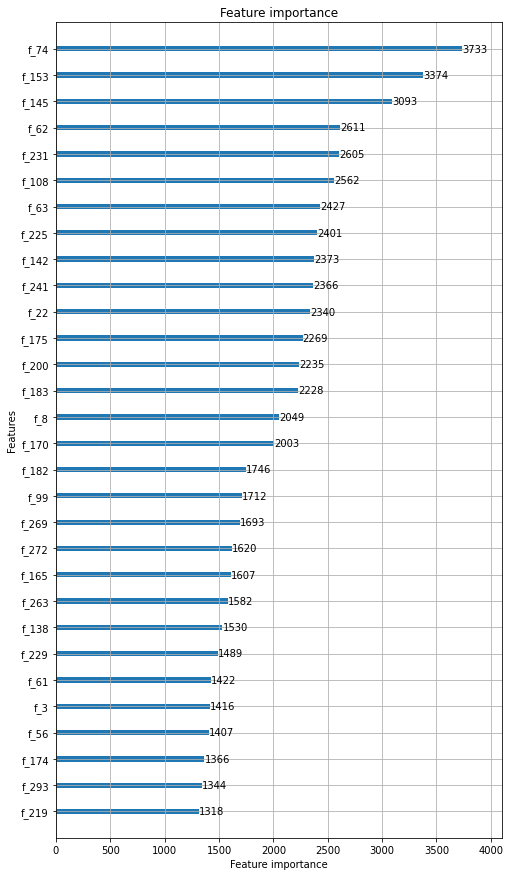

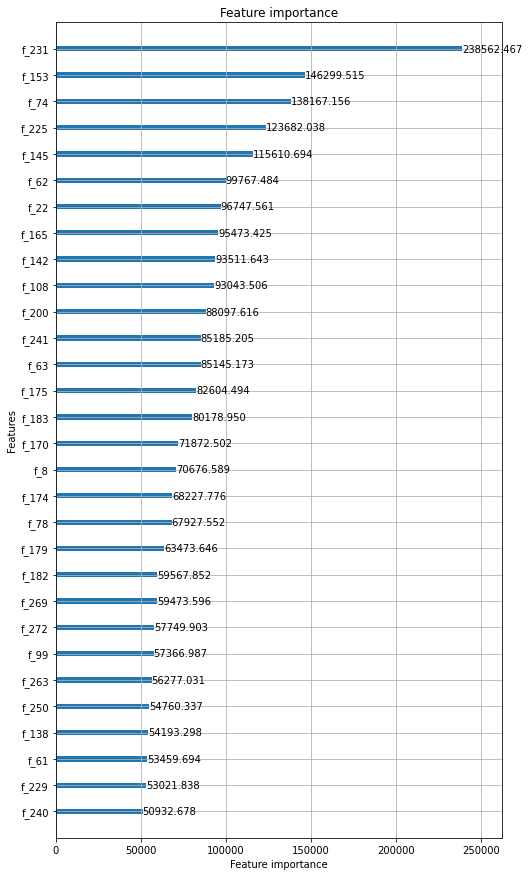

[50]	training's rmse: 0.911305	training's pearsonr: 0.166934


[100]	training's rmse: 0.908661	training's pearsonr: 0.18161


[150]	training's rmse: 0.906137	training's pearsonr: 0.196678


[200]	training's rmse: 0.904927	training's pearsonr: 0.206904


[250]	training's rmse: 0.903605	training's pearsonr: 0.215182


[300]	training's rmse: 0.902764	training's pearsonr: 0.221694


[350]	training's rmse: 0.900886	training's pearsonr: 0.230924


[400]	training's rmse: 0.89926	training's pearsonr: 0.240311


[450]	training's rmse: 0.897683	training's pearsonr: 0.249672


[500]	training's rmse: 0.896403	training's pearsonr: 0.257344


[550]	training's rmse: 0.895216	training's pearsonr: 0.263435


[600]	training's rmse: 0.893953	training's pearsonr: 0.269724


[650]	training's rmse: 0.89305	training's pearsonr: 0.275517


[700]	training's rmse: 0.892342	training's pearsonr: 0.279963


[750]	training's rmse: 0.891857	training's pearsonr: 0.283086


[800]	training's rmse: 0.891069	training's pearsonr: 0.286448


[850]	training's rmse: 0.889992	training's pearsonr: 0.291427


[900]	training's rmse: 0.889067	training's pearsonr: 0.296142


[950]	training's rmse: 0.88825	training's pearsonr: 0.300404


[1000]	training's rmse: 0.887208	training's pearsonr: 0.304917


[1050]	training's rmse: 0.885806	training's pearsonr: 0.310867


[1100]	training's rmse: 0.884745	training's pearsonr: 0.315778


[1150]	training's rmse: 0.884187	training's pearsonr: 0.319542


[1200]	training's rmse: 0.88309	training's pearsonr: 0.323846


[1250]	training's rmse: 0.881915	training's pearsonr: 0.32876


[1300]	training's rmse: 0.880991	training's pearsonr: 0.332958


[1350]	training's rmse: 0.880025	training's pearsonr: 0.337089


[1400]	training's rmse: 0.878636	training's pearsonr: 0.342345


[1450]	training's rmse: 0.877767	training's pearsonr: 0.346259


[1500]	training's rmse: 0.877799	training's pearsonr: 0.348404


[1550]	training's rmse: 0.877423	training's pearsonr: 0.350628


[1600]	training's rmse: 0.875982	training's pearsonr: 0.354742


[1650]	training's rmse: 0.875007	training's pearsonr: 0.358918


[1700]	training's rmse: 0.874185	training's pearsonr: 0.362189


[1750]	training's rmse: 0.873417	training's pearsonr: 0.365619


[1800]	training's rmse: 0.872681	training's pearsonr: 0.368637


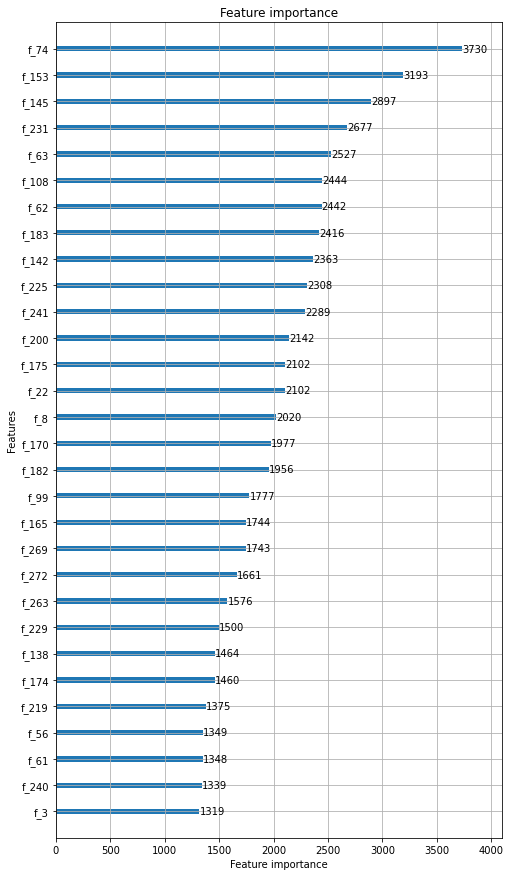

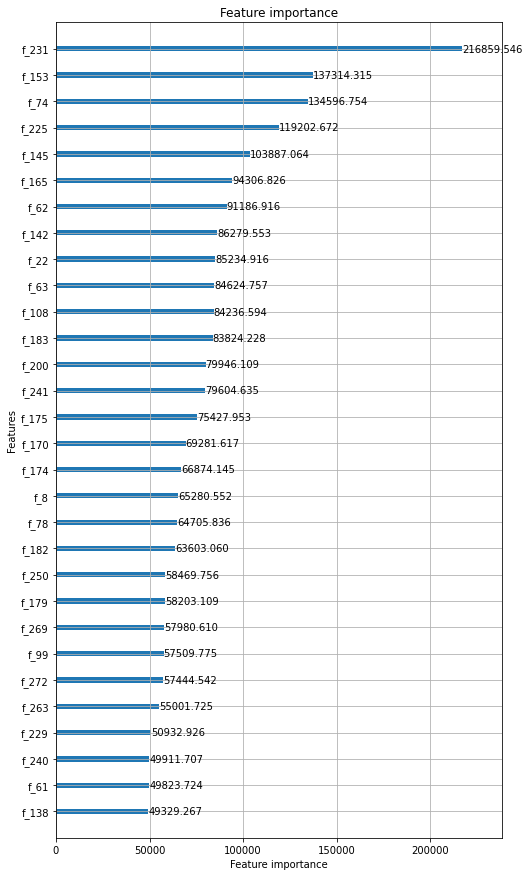

In [14]:
seeds = [
    2, 3, 5, 7, 11, 
    13, 17, 19, 23, 29, 
    #31, 37, 41, 43, 47, 
    #53, 59, 61, 67, 71, 
    #73, 79, 83, 89, 97,
]
models = list()

for seed in seeds:
    _model_params = dict(model_params)
    _model_params["seed"] = seed
    _model_params["drop_seed"] = seed
    
    train_dset = lgb.Dataset(
        data=features,
        label=target.target.values,
        free_raw_data=True
    )
    model = lgb.train(
        params=_model_params,
        train_set=train_dset,
        valid_sets=[train_dset,],
        feval=pearsonr,
        callbacks=[lgb.log_evaluation(period=50)],
    )
    models.append(model)

    lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
    lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
    plt.show()

In [15]:
for seed,model in zip(seeds,models): 
    model.save_model(f"../ump-artifacts/lgbm-dart/lgbm-seed{seed}.txt")

***
## inference

In [16]:
if current_env == "kaggle":

    import ubiquant
    env = ubiquant.make_env()  
    iter_test = env.iter_test()
    
    features = [f"f_{i}" for i in range(300)]
    for (test_df, sample_prediction_df) in iter_test:  
        preds = [model.predict(test_df[features]) for model in models]
        sample_prediction_df['target'] = np.mean(preds, axis=0)
        env.predict(sample_prediction_df) 
        display(sample_prediction_df)

***